# Fine Tuning
## TensorFlow 2 Detection Model Zoo
### mobilenet_ssd_v1

Reference: https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

In [1]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageColor, ImageDraw, ImageFont
from six import BytesIO
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils
from sklearn.model_selection import train_test_split

import concurrent.futures
import requests
import tarfile

from datetime import datetime
import time

%matplotlib inline

In [2]:
BATCH_SIZE = 8
NUM_CLASSES = 4  # Updated number of classes

# Class IDs for the desired classes
d_00_class_id = 1
d_10_class_id = 2
d_20_class_id = 3
d_40_class_id = 4

# Updated category_index
category_index = {
    d_00_class_id: {'id': d_00_class_id, 'name': 'D00'},
    d_10_class_id: {'id': d_10_class_id, 'name': 'D10'},
    d_20_class_id: {'id': d_20_class_id, 'name': 'D20'},
    d_40_class_id: {'id': d_40_class_id, 'name': 'D40'},
}

In [32]:
# Function to load an image and convert it to numpy array with uint8
def load_image_into_numpy_array(image_path):
    return np.array(Image.open(image_path))

# Function to resize image and adjust bounding box coordinates to ratio
def resize_image_and_boxes(image, boxes, target_size):
    orig_height, orig_width = image.shape[:2]
    target_height, target_width = target_size

    # Resize image
    image = tf.image.resize(image, target_size).numpy()

    if boxes.size > 0:  # Check if boxes are not empty
        # Adjust bounding boxes to ratio
        boxes[:, [0, 2]] *= target_height / orig_height
        boxes[:, [1, 3]] *= target_width / orig_width

        # Clip bounding boxes to be within [0, 1]
        boxes = np.clip(boxes, 0, 1)

    return image, boxes

# Function to process a single image and annotation
def process_image_annotation(image_file, image_dir, annotation_dir, target_size=(640, 640)):
    image_path = os.path.join(image_dir, image_file)
    annotation_path = os.path.join(annotation_dir, image_file.replace(".jpg", ".xml"))

    if not os.path.exists(annotation_path):
        print(f"Annotation not found for {image_file}")
        return None

    # Load image
    image_np = load_image_into_numpy_array(image_path)

    # Parse annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    classes = []
    orig_height, orig_width = image_np.shape[:2]
    for member in root.findall('object'):
        class_name = member[0].text
        if class_name == 'D00':
            class_id = d_00_class_id
        elif class_name == 'D10':
            class_id = d_10_class_id
        elif class_name == 'D20':
            class_id = d_20_class_id
        elif class_name == 'D40':
            class_id = d_40_class_id
        else:
            continue

        classes.append(class_id)
        bndbox = member.find('bndbox')
        ymin = int(bndbox.find('ymin').text) / orig_height
        xmin = int(bndbox.find('xmin').text) / orig_width
        ymax = int(bndbox.find('ymax').text) / orig_height
        xmax = int(bndbox.find('xmax').text) / orig_width
        boxes.append([ymin, xmin, ymax, xmax])

    if not classes:  # Skip images without any of the desired classes
        return None

    boxes = np.array(boxes, dtype=np.float32)
    classes = np.array(classes, dtype=np.int32)

    # Resize image
    image_np, boxes = resize_image_and_boxes(image_np, boxes, target_size)

    # Convert image to uint8
    image_np = image_np.astype(np.uint8)

    return image_np, boxes, classes

def create_tfrecord(image_dir, annotation_dir, output_path, target_size=(640, 640), max_boxes=20, num_images=None, max_workers=4):
    image_files = sorted(os.listdir(image_dir))
    if num_images:
        image_files = image_files[:num_images]

    def process_file(image_file):
        return process_image_annotation(image_file, image_dir, annotation_dir, target_size)

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_file, image_files))

    with tf.io.TFRecordWriter(output_path) as writer:
        for result in results:
            if result is not None:
                image_np, boxes, classes = result
                if boxes.size == 0:  # Skip images without bounding boxes
                    continue

                image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
                box_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
                zero_indexed_groundtruth_classes = tf.convert_to_tensor(classes - 1, dtype=tf.int32)
                one_hot_classes = tf.one_hot(zero_indexed_groundtruth_classes, NUM_CLASSES)
                
                # Calculate padding
                box_padding = tf.maximum(max_boxes - tf.shape(box_tensor)[0], 0)
                class_padding = tf.maximum(max_boxes - tf.shape(one_hot_classes)[0], 0)
                
                # Padding boxes and classes
                padded_boxes = tf.pad(box_tensor, [[0, box_padding], [0, 0]], mode='CONSTANT', constant_values=0)
                padded_classes = tf.pad(one_hot_classes, [[0, class_padding], [0, 0]], mode='CONSTANT', constant_values=0)
                
                feature = {
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(tf.cast(image_tensor, tf.uint8)).numpy()])),
                    'boxes': tf.train.Feature(float_list=tf.train.FloatList(value=padded_boxes.numpy().flatten())),
                    'classes': tf.train.Feature(float_list=tf.train.FloatList(value=padded_classes.numpy().flatten()))
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())

# Create TFRecord
image_dir = '../data-collection/RDD2022/Japan_filtered/filtered/images'
annotation_dir = '../data-collection/RDD2022/Japan_filtered/filtered/annotations'
tfrecord_path = '../data-collection/RDD2022/Japan_filtered/dataset_japan_filtered.tfrecord'
create_tfrecord(image_dir, annotation_dir, tfrecord_path)

In [3]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'boxes': tf.io.FixedLenFeature([20 * 4], tf.float32),  # max_boxes * 4
        'classes': tf.io.FixedLenFeature([20 * NUM_CLASSES], tf.float32)  # max_boxes * num_classes
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [640, 640, 3])
    boxes = tf.reshape(example['boxes'], [20, 4])
    classes = tf.reshape(example['classes'], [20, NUM_CLASSES])
    return image, boxes, classes

def load_tfrecord_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Load dataset from TFRecord
tfrecord_path = '../data-collection/RDD2022/Japan_filtered/dataset_japan_filtered.tfrecord'
loaded_dataset = load_tfrecord_dataset(tfrecord_path, BATCH_SIZE)

print('Done loading TFRecord data.')

def debug_print_dataset(dataset, name):
    print(f"{name} dataset samples:")
    for image, boxes, classes in dataset.take(1):
        print("Image shape:", image.shape)
        print("Boxes shape:", boxes.shape)
        print("Classes shape:", classes.shape)
        break

# Debug print to check dataset
debug_print_dataset(loaded_dataset, "Loaded")

Done loading TFRecord data.
Loaded dataset samples:
Image shape: (8, 640, 640, 3)
Boxes shape: (8, 20, 4)
Classes shape: (8, 20, 4)


In [4]:
# Function to count the number of elements in a dataset
def get_dataset_size(dataset):
    return sum(1 for _ in dataset)

In [5]:
# Split data into train, validation, and test sets
def split_dataset(dataset, train_size=0.8, val_size=0.2):
    dataset_size = get_dataset_size(dataset)
    print("Dataset size:", dataset_size)
    train_size = int(train_size * dataset_size)
    val_size = int(val_size * dataset_size)
    #test_size = dataset_size - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    #test_dataset = dataset.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, train_size, val_size

train_dataset, val_dataset, train_size, val_size = split_dataset(loaded_dataset)

Dataset size: 517


In [6]:
# Apply prefetch to each dataset
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
def extract_and_print_single_example_from_batch(dataset):
    for data in dataset.take(1):
        images, boxes, classes = data
        
        # Print the shape of the batch
        print(f"Batch image shape: {images.shape}")
        print(f"Batch boxes shape: {boxes.shape}")
        print(f"Batch classes shape: {classes.shape}")

        # Print the first example from the batch
        single_image = images[0]
        single_boxes = boxes[0]
        single_classes = classes[0]
        
        print(f"Single Image shape: {single_image.shape}")
        print(f"Single Bounding Boxes: {single_boxes.numpy()}")
        print(f"Single Classes: {single_classes.numpy()}")

# Assuming loaded_dataset is the dataset you want to inspect
extract_and_print_single_example_from_batch(val_dataset)

Batch image shape: (8, 640, 640, 3)
Batch boxes shape: (8, 20, 4)
Batch classes shape: (8, 20, 4)
Single Image shape: (640, 640, 3)
Single Bounding Boxes: [[0.4924445  0.00177778 1.         0.432     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]

In [8]:
# Function to visualize detections
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None):
    """Wrapper function to visualize detections."""
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.0)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

# Function to filter out padding boxes and corresponding classes
def filter_padded_boxes_and_classes(boxes, one_hot_classes):
    valid_indices = np.where(~np.all(boxes == 0, axis=1))[0]
    filtered_boxes = boxes[valid_indices]
    filtered_one_hot_classes = one_hot_classes[valid_indices]
    class_indices = np.argmax(filtered_one_hot_classes, axis=-1) + 1  # Adjust to 1-based index
    return filtered_boxes, class_indices

# Set visualization parameters
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

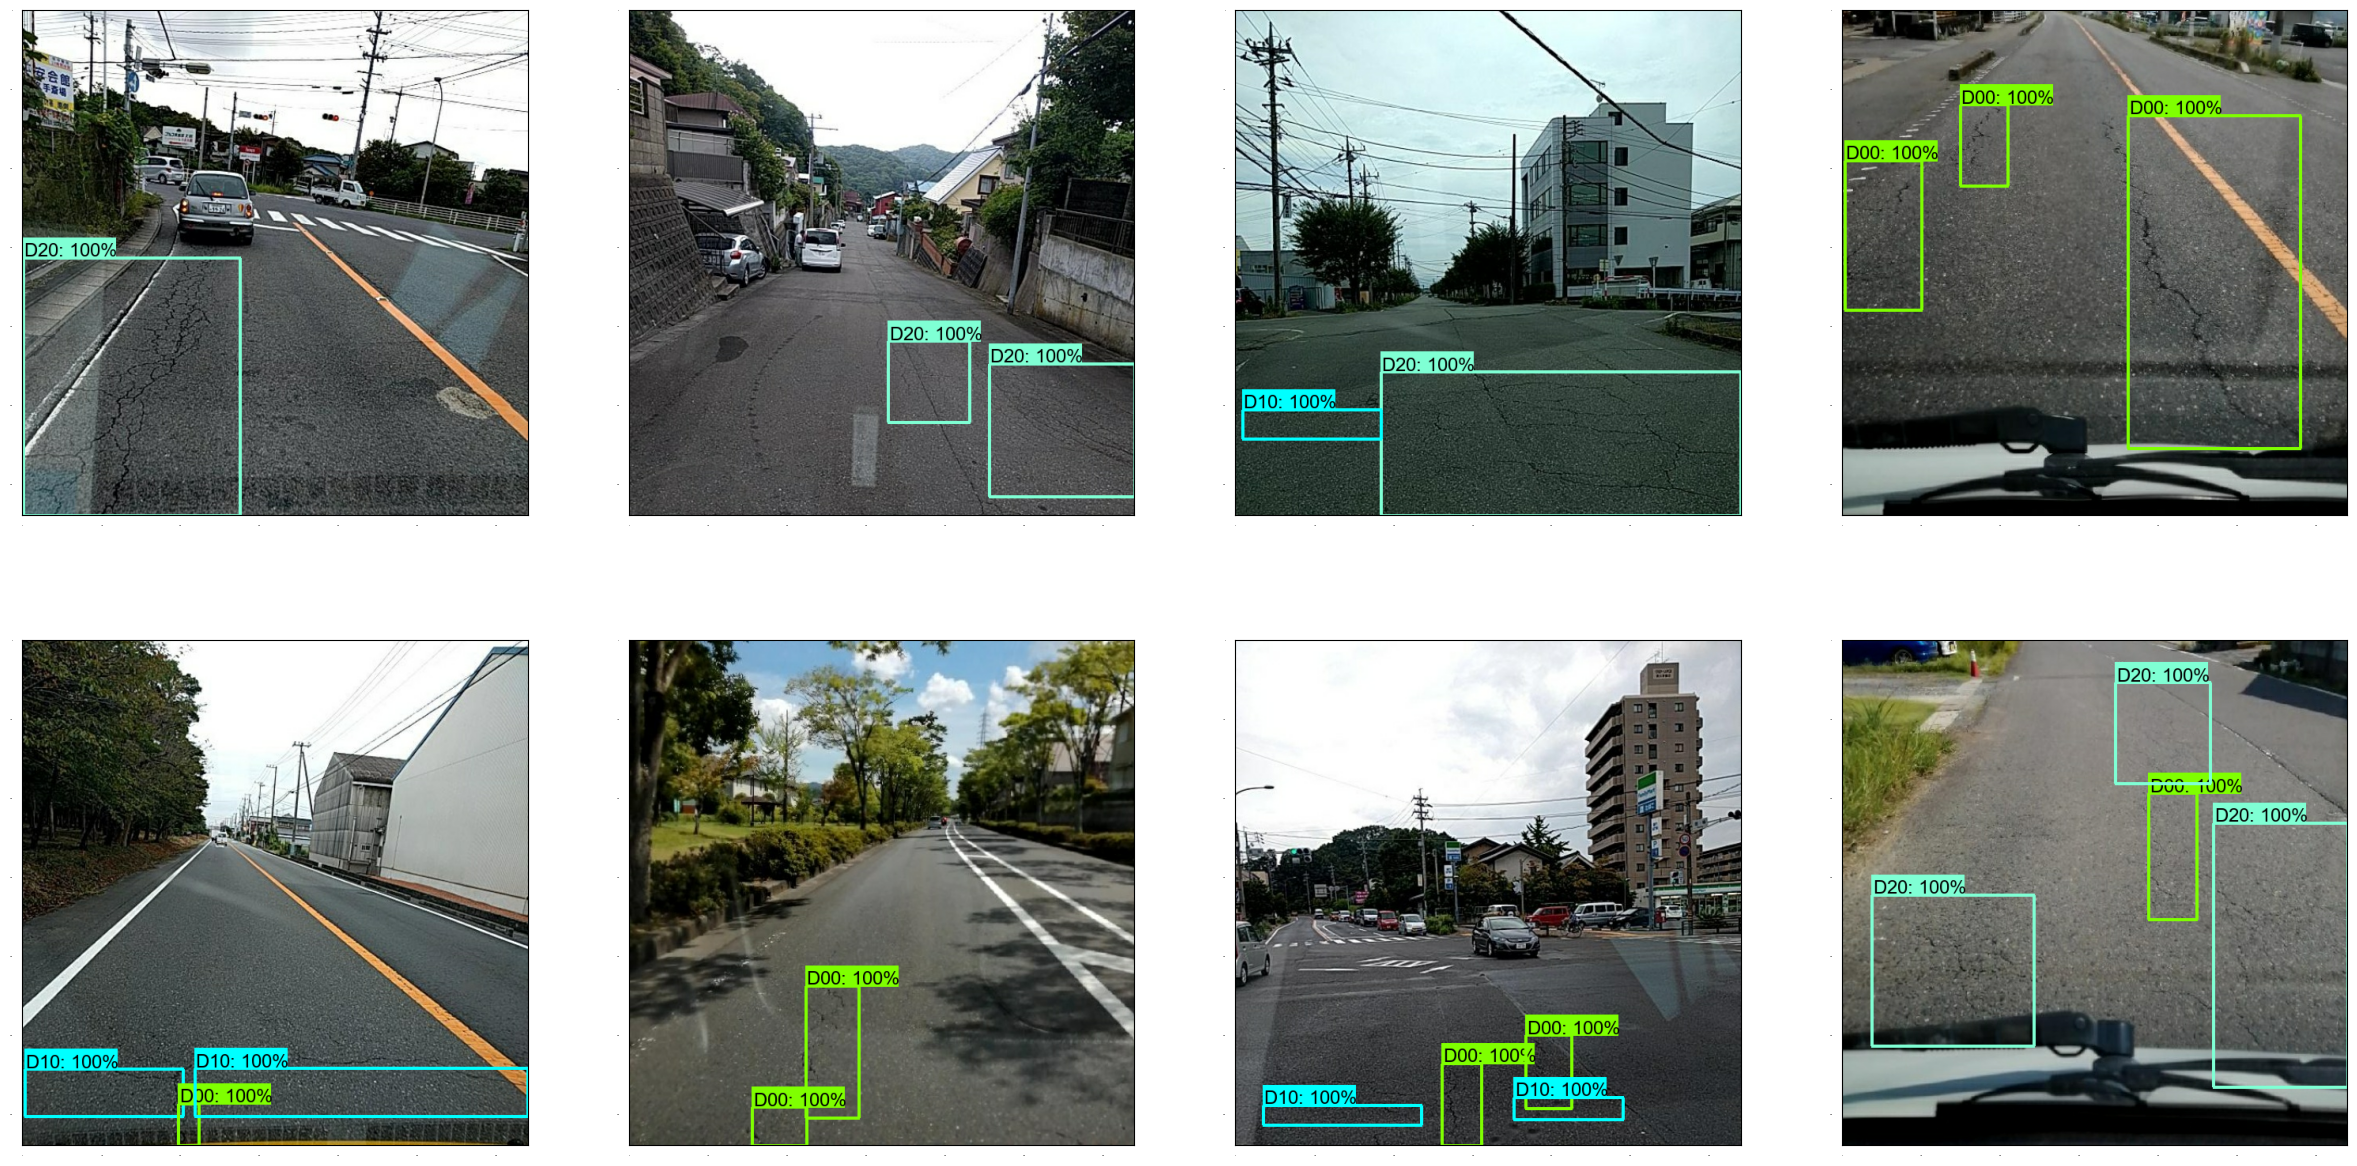

In [9]:
# Visualize the batch
def visualize_batch(dataset, batch_size, category_index):
    num_boxes_max = 20
    dummy_scores = np.array([1.0] * num_boxes_max, dtype=np.float32)  # give boxes a score of 100%

    # Create an iterator for the dataset
    dataset_iterator = iter(dataset)

    # Retrieve one batch from the dataset
    image_batch, box_batch, class_batch = next(dataset_iterator)

    # Convert the tensors to numpy arrays for visualization
    image_batch_np = image_batch.numpy()
    box_batch_np = box_batch.numpy()
    class_batch_np = class_batch.numpy()

    plt.figure(figsize=(30, 15))
    for idx in range(batch_size):
        plt.subplot(2, 4, idx + 1)
        image = image_batch_np[idx]
        filtered_boxes, filtered_classes = filter_padded_boxes_and_classes(box_batch_np[idx], class_batch_np[idx])
        filtered_dummy_scores = dummy_scores[:filtered_boxes.shape[0]]

        # Temporarily convert image to uint8 for visualization
        image_uint8 = (image * 255).astype(np.uint8)
        plot_detections(
            image_uint8,
            filtered_boxes,
            filtered_classes,
            filtered_dummy_scores,  # Use the correct number of scores
            category_index)

    plt.show()

visualize_batch(val_dataset, 8, category_index)

In [10]:
# URL for the pretrained model
model_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz"
output_dir = "../models/my_custom_model"

In [11]:
# Function to download and extract model into a specific directory
def download_and_extract_model(url, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    response = requests.get(url, stream=True)
    tar_file_path = os.path.join(output_dir, "model.tar.gz")
    with open(tar_file_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    with tarfile.open(tar_file_path, "r:gz") as tar:
        tar.extractall(path=output_dir)
    os.remove(tar_file_path)

# Download and extract the model checkpoint into a custom directory
download_and_extract_model(model_url, output_dir)

In [32]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = NUM_CLASSES
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = os.path.join(output_dir, 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8', 'checkpoint', 'ckpt-0')

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# Custom initializer
initializer = tf.keras.initializers.TruncatedNormal(stddev=0.03, seed=42)

# Apply the initializer to specific layers if needed
def custom_model_builder(model_config, is_training):
    detection_model = model_builder.build(model_config=model_config, is_training=is_training)
    # Call the model with a sample input to create the weights
    image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
    prediction_dict = detection_model.predict(image, shapes)
    _ = detection_model.postprocess(prediction_dict, shapes)
    
    # Initialize the weights
    for var in detection_model.trainable_variables:
        if 'kernel' in var.name:
            var.assign(initializer(var.shape))
    return detection_model

# Build the model with custom initialization
detection_model = custom_model_builder(model_config=model_config, is_training=True)

# Alternatively, you can use the original build function if needed
# detection_model = model_builder.build(model_config=model_config, is_training=True)

# restore the weights for the parts you want from the checkpoint
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor)

# Load the weights
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Verify weights restoration
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [33]:
# Print the number of parameters for each layer
total_params = 0

trainable_variables = detection_model.trainable_variables

for var in trainable_variables:
    var_params = tf.size(var).numpy()  # Number of parameters in each variable
    total_params += var_params
    print(f"{var.name}: {var_params} parameters")

print(f"Total number of trainable variables: {len(trainable_variables)}")
print(f"Total number of trainable parameters: {total_params}")

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0: 55296 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0: 24 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0: 69120 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0: 30 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0: 589824 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0: 589824 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/Box

In [34]:
# Set learning phase to True for training
tf.keras.backend.set_learning_phase(True)

# Initialize directories and TensorBoard callbacks
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
train_summary_writer = tf.summary.create_file_writer(log_dir + '/train')
val_summary_writer = tf.summary.create_file_writer(log_dir + '/val')

# Set up the learning rate schedule
initial_learning_rate = 0.0005
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=413,  # Given decay steps
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
#optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9)

# Specify the layers to fine-tune
#trainable_variables = detection_model.trainable_variables
#to_fine_tune = []
#prefixes_to_train = [
#    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
#    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
#]
#for var in trainable_variables:
#    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
#        to_fine_tune.append(var)

# Specify all trainable variables
to_fine_tune = detection_model.trainable_variables

total_params = sum([tf.size(var).numpy() for var in to_fine_tune])
print(f"Total number of trainable parameters for fine-tuning: {total_params}")

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(b_size, image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
        shapes = tf.constant(b_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat([model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

@tf.function
def val_step(b_size, image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
    shapes = tf.constant(b_size * [[640, 640, 3]], dtype=tf.int32)
    detection_model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    preprocessed_images = tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0)
    prediction_dict = detection_model.predict(preprocessed_images, shapes)
    losses_dict = detection_model.loss(prediction_dict, shapes)
    total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
    return total_loss

Total number of trainable parameters for fine-tuning: 10891382


In [35]:
# Get current date and time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Initialize checkpoint directory with current date and time
checkpoint_dir = f"./checkpoints_B{BATCH_SIZE}_{current_time}"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Initialize checkpoint and checkpoint manager
checkpoint = tf.train.Checkpoint(model=detection_model, optimizer=optimizer)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=1)

epochs = 100  # Increased the number of epochs
# Get steps per epoch
steps_per_epoch = train_size
val_steps_per_epoch = val_size

print(f"Batch_size: {BATCH_SIZE}, Steps per epoch: {steps_per_epoch}, Validation steps per epoch: {val_steps_per_epoch}")

Batch_size: 8, Steps per epoch: 413, Validation steps per epoch: 103


In [36]:
print('Start fine-tuning!', flush=True)
start_time = time.time()
best_val_loss = float('inf')

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = 0
    print(f'Starting epoch {epoch + 1}/{epochs}')
    for step, (image_batch, box_batch, class_batch) in enumerate(train_dataset):
        image_list = [tf.expand_dims(image, axis=0) for image in image_batch]
        box_list = [box for box in box_batch]
        class_list = [cls for cls in class_batch]
        
        total_loss = train_step_fn(len(image_list), image_list, box_list, class_list)
        train_loss += total_loss

        # Print progress every 50 steps
        if step % 50 == 0:
            print(f'Training - Epoch {epoch + 1}/{epochs}, Step {step + 1}/{steps_per_epoch}, Batch Loss: {total_loss.numpy()}', flush=True)
    
    train_loss /= steps_per_epoch

    # Validation
    val_loss = 0
    val_steps = 0
    print(f'Validating epoch {epoch + 1}/{epochs}')
    for step, (image_batch, box_batch, class_batch) in enumerate(val_dataset):
        image_list = [tf.expand_dims(image, axis=0) for image in image_batch]
        box_list = [box for box in box_batch]
        class_list = [cls for cls in class_batch]

        total_loss = val_step(len(image_list), image_list, box_list, class_list)
        val_loss += total_loss
        val_steps += 1

        # Print progress every 50 steps
        if step % 50 == 0:
            print(f'Validating - Epoch {epoch + 1}/{epochs}, Step {step + 1}/{val_steps_per_epoch}, Batch Loss: {total_loss.numpy()}', flush=True)

    val_loss /= val_steps

    # Log training and validation metrics
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        manager.save()
        print(f'Saving best model with batch size {BATCH_SIZE} at epoch {epoch + 1}')

    epoch_elapsed_time = time.time() - epoch_start_time
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.numpy()}, Val Loss: {val_loss.numpy()}, Epoch Time elapsed: {epoch_elapsed_time:.2f} seconds, Total Time elapsed: {elapsed_time:.2f} seconds', flush=True)

print('Done fine-tuning!')

Start fine-tuning!
Starting epoch 1/100
Training - Epoch 1/100, Step 1/413, Batch Loss: 4.152306079864502
Training - Epoch 1/100, Step 51/413, Batch Loss: 1.3703585863113403
Training - Epoch 1/100, Step 101/413, Batch Loss: 1.459545612335205
Training - Epoch 1/100, Step 151/413, Batch Loss: 1.2861924171447754
Training - Epoch 1/100, Step 201/413, Batch Loss: 1.1939916610717773
Training - Epoch 1/100, Step 251/413, Batch Loss: 1.519425630569458
Training - Epoch 1/100, Step 301/413, Batch Loss: 1.921474814414978
Training - Epoch 1/100, Step 351/413, Batch Loss: 1.2654099464416504
Training - Epoch 1/100, Step 401/413, Batch Loss: 1.1678693294525146
Validating epoch 1/100
Validating - Epoch 1/100, Step 1/103, Batch Loss: 1.4067033529281616
Validating - Epoch 1/100, Step 51/103, Batch Loss: 1.3444539308547974
Validating - Epoch 1/100, Step 101/103, Batch Loss: 1.3351831436157227
Saving best model with batch size 8 at epoch 1
Epoch 1/100, Train Loss: 1.6300541162490845, Val Loss: 1.492981672

KeyboardInterrupt: 

In [37]:
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_dir = './checkpoints_B8_20240617-055644'
best_checkpoint_path = os.path.join(checkpoint_dir, 'ckpt-20')

# Load pipeline config and build detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Load the entire model
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(best_checkpoint_path).expect_partial()

print(f"Restored from {best_checkpoint_path}")

Restored from ./checkpoints_B8_20240617-055644\ckpt-20


In [38]:
def apply_nms(detections, iou_threshold=0.15, score_threshold=0.15, max_output_size=100):
    boxes = detections['detection_boxes'][0]
    scores = detections['detection_scores'][0]
    classes = detections['detection_classes'][0]

    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_output_size=max_output_size,
        iou_threshold=iou_threshold, score_threshold=score_threshold)

    selected_boxes = tf.gather(boxes, selected_indices)
    selected_scores = tf.gather(scores, selected_indices)
    selected_classes = tf.gather(classes, selected_indices)

    return selected_boxes, selected_scores, selected_classes

In [39]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    #return detections

    # Apply NMS
    selected_boxes, selected_scores, selected_classes = apply_nms(detections)

    return selected_boxes, selected_scores, selected_classes

In [40]:
# Function to extract boxes, scores, and classes from detections
def extract_detections(detections):
    if isinstance(detections, tuple):
        boxes, scores, classes = detections
    else:
        boxes = detections['detection_boxes'][0]
        scores = detections['detection_scores'][0]
        classes = detections['detection_classes'][0]
    return boxes, scores, classes

In [41]:
# Inspect test batch classes
def inspect_test_batch_classes(dataset, batch_size):
    dataset_iterator = iter(dataset)
    image_batch, box_batch, class_batch = next(dataset_iterator)
    image_batch_np = image_batch.numpy()

    for idx in range(batch_size):
        image = image_batch_np[idx]

        input_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
        detections = detect(input_tensor)
        
        boxes, scores, classes = extract_detections(detections)

        print(f"Image {idx + 1}")
        print("Predicted Classes:", classes.numpy())
        print("Scores:", scores.numpy())
        print("\n")

# Inspect the class predictions for the test dataset
inspect_test_batch_classes(val_dataset, BATCH_SIZE)

Image 1
Predicted Classes: [2.]
Scores: [0.22853279]


Image 2
Predicted Classes: [2.]
Scores: [0.22853279]


Image 3
Predicted Classes: [2.]
Scores: [0.22853279]


Image 4
Predicted Classes: [2.]
Scores: [0.22853279]


Image 5
Predicted Classes: [2.]
Scores: [0.22853279]


Image 6
Predicted Classes: [2.]
Scores: [0.22853279]


Image 7
Predicted Classes: [2.]
Scores: [0.22853279]


Image 8
Predicted Classes: [2.]
Scores: [0.22853279]




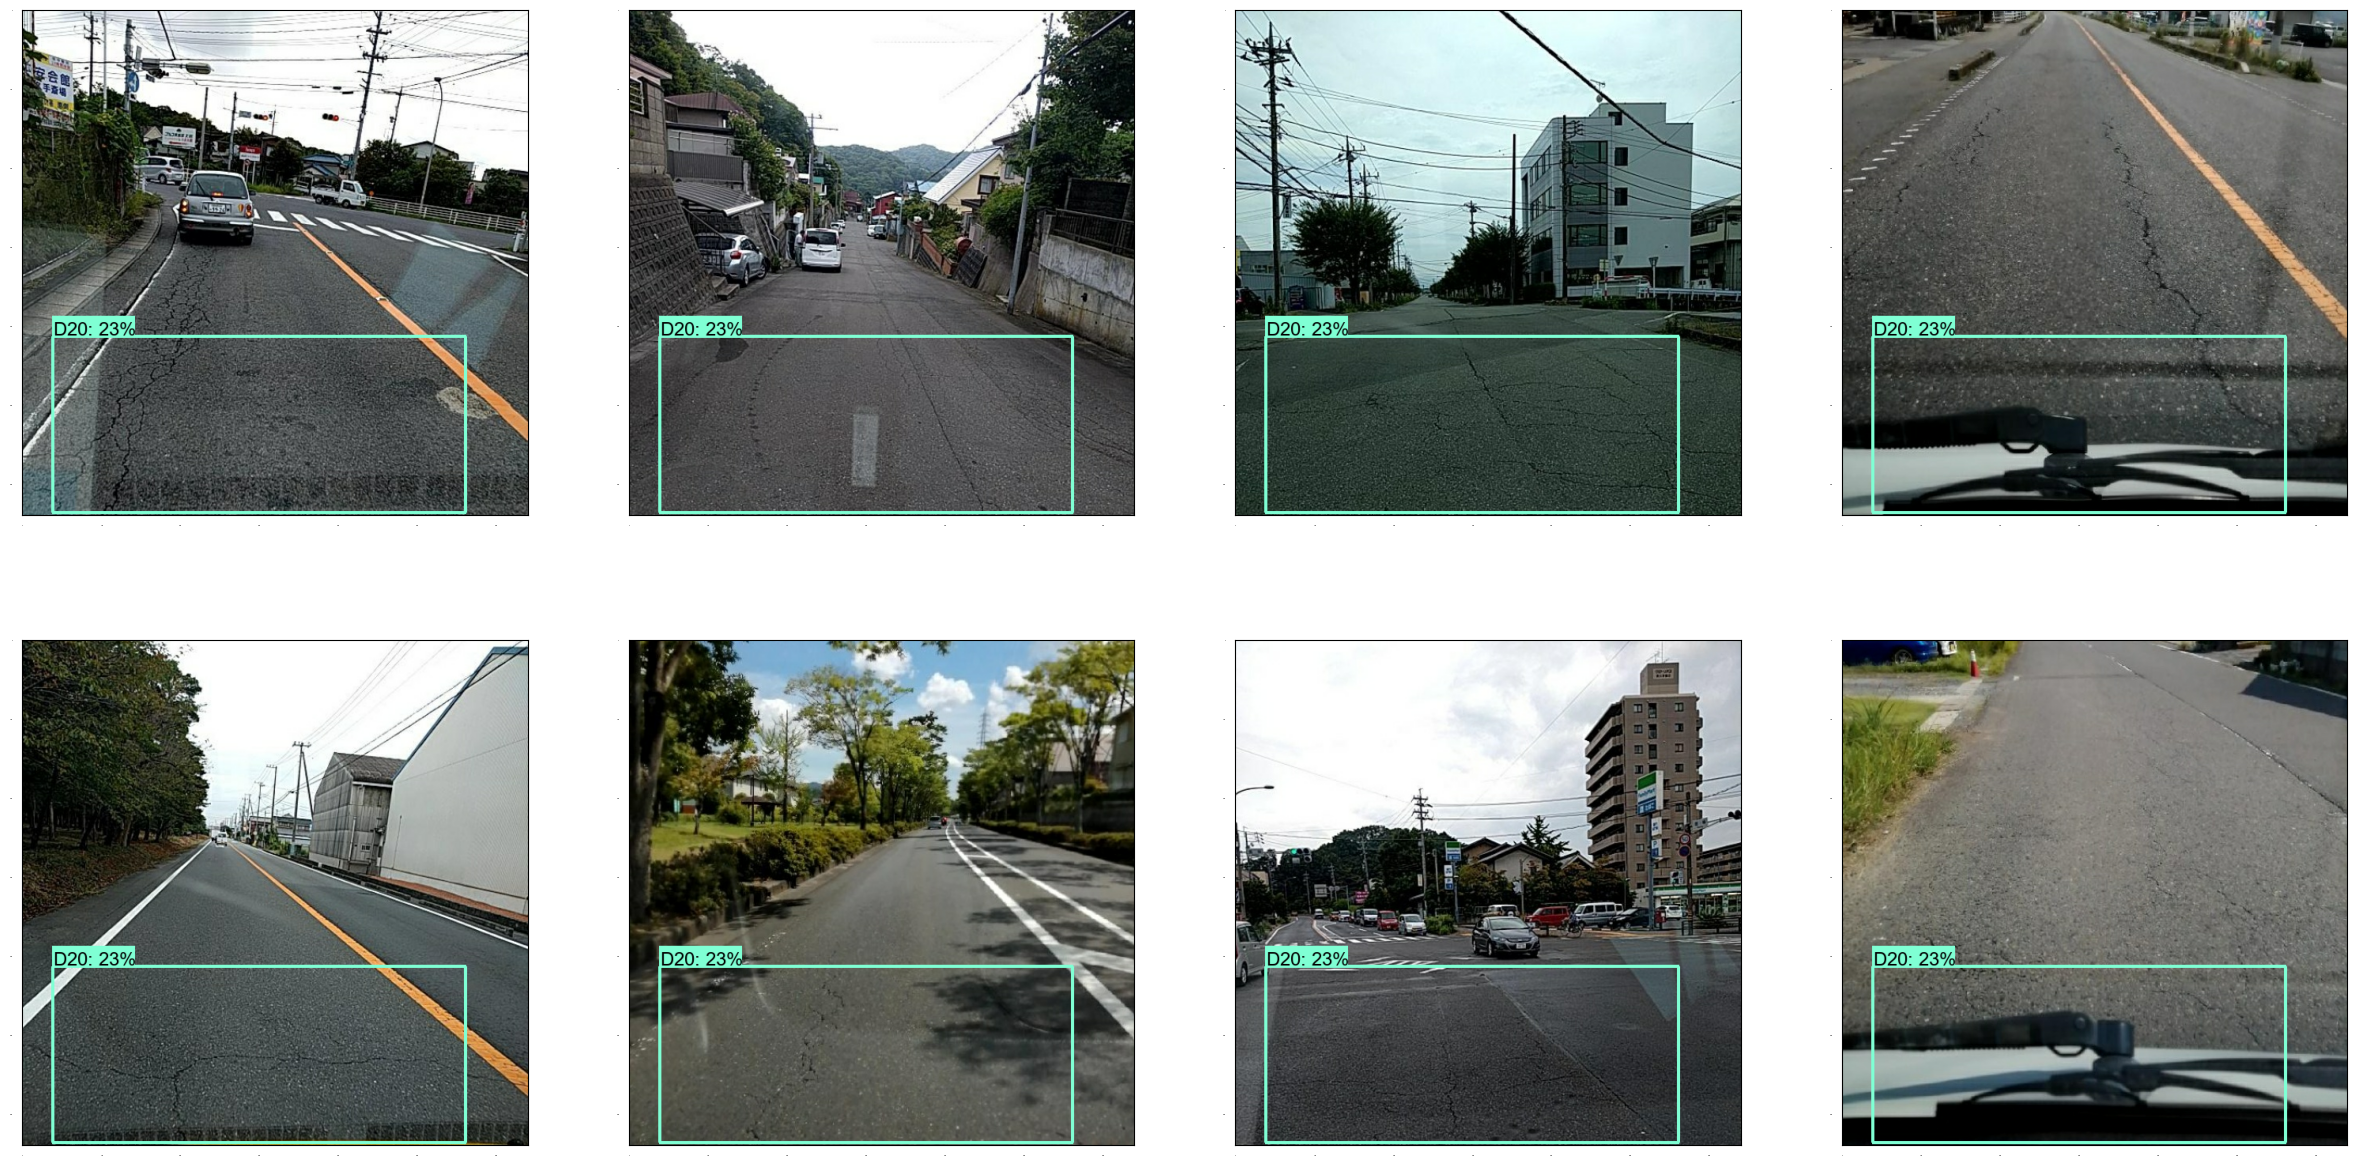

In [42]:
# Visualize test batch
def visualize_test_batch(dataset, batch_size, category_index):
    dataset_iterator = iter(dataset)
    image_batch, box_batch, class_batch = next(dataset_iterator)
    image_batch_np = image_batch.numpy()

    plt.figure(figsize=(30, 15))
    for idx in range(batch_size):
        plt.subplot(2, 4, idx + 1)
        image = image_batch_np[idx]

        input_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
        detections = detect(input_tensor)

        boxes, scores, classes = extract_detections(detections)

        image_uint8 = (image * 255).astype(np.uint8)
        plot_detections(
            image_uint8,
            boxes.numpy(),
            classes.numpy().astype(np.int32) + 1,  # Category index typically starts at 1
            scores.numpy(),
            category_index)

    plt.show()

# Test the visualization with the test dataset
visualize_test_batch(val_dataset, 8, category_index)

In [138]:
def calculate_iou(gt_boxes, pred_boxes):
    """Calculate IoU between ground truth boxes and predicted boxes."""
    # Expand dimensions to [N, 1, 4] and [1, M, 4] for broadcast
    gt_boxes = np.expand_dims(gt_boxes, 1)
    pred_boxes = np.expand_dims(pred_boxes, 0)

    # Calculate intersection
    intersection_min = np.maximum(gt_boxes[..., :2], pred_boxes[..., :2])
    intersection_max = np.minimum(gt_boxes[..., 2:], pred_boxes[..., 2:])
    intersection_area = np.maximum(intersection_max - intersection_min, 0).prod(axis=2)

    # Calculate union
    gt_area = (gt_boxes[..., 2:] - gt_boxes[..., :2]).prod(axis=2)
    pred_area = (pred_boxes[..., 2:] - pred_boxes[..., :2]).prod(axis=2)
    union_area = gt_area + pred_area - intersection_area

    # Calculate IoU
    iou = intersection_area / np.maximum(union_area, 1e-10)
    return iou

def calculate_map(gt_boxes, gt_classes, pred_boxes, pred_classes, pred_scores, iou_threshold=0.5):
    """Calculate mean Average Precision (mAP) for a single image."""
    # Sort predictions by score in descending order
    sorted_indices = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_indices]
    pred_classes = pred_classes[sorted_indices]
    pred_scores = pred_scores[sorted_indices]

    # Initialize variables to store true positives, false positives, and false negatives
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    fn = len(gt_boxes)

    # Calculate IoU between each predicted box and each ground truth box
    ious = calculate_iou(gt_boxes, pred_boxes)

    for i in range(len(pred_boxes)):
        max_iou_idx = np.argmax(ious[:, i])
        max_iou = ious[max_iou_idx, i]

        if max_iou >= iou_threshold and pred_classes[i] == gt_classes[max_iou_idx]:
            tp[i] = 1
            fn -= 1
            ious[max_iou_idx, :] = 0  # Remove matched ground truth box
        else:
            fp[i] = 1

    # Calculate precision and recall
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / (cum_tp + fn)

    # Calculate Average Precision (AP)
    ap = 0
    for r in np.linspace(0, 1, 11):
        if np.any(recall >= r):
            ap += np.max(precision[recall >= r])
    ap /= 11

    return ap

def evaluate_map(test_dataset, detection_model, category_index, iou_threshold=0.5):
    aps = []
    for image_batch, box_batch, class_batch in test_dataset:
        for i in range(image_batch.shape[0]):
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_batch[i], axis=0), dtype=tf.float32)
            detections = detect(input_tensor)

            pred_boxes = detections[0].numpy()
            pred_scores = detections[1].numpy()
            pred_classes = detections[2].numpy()

            gt_boxes = box_batch[i].numpy()
            gt_classes = np.argmax(class_batch[i].numpy(), axis=-1) + 1
            ap = calculate_map(gt_boxes, gt_classes, pred_boxes, pred_classes.astype(np.int32), pred_scores, iou_threshold)
            aps.append(ap)

    mean_ap = np.mean(aps)
    print(f"mAP: {mean_ap:.4f}")

In [139]:
evaluate_map(val_dataset, detection_model, category_index)

mAP: 0.0000
